# 1D Burgers' equation, finite volume, central scheme

_Gilbert François Duivesteijn_

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.linalg import toeplitz

from IPython import display

## Non linear partial differential equation

Let's examin the pde
\begin{align}\label{eq:pde1}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0.
\end{align}
With
\begin{align}
f(u) \equiv u
\end{align}
we have the convection equation, a linear equation which can be solved with finite difference. Examples of how to solve these type of equations is given in the notebook(s) "1D wave equation, finite difference, ...".  When
\begin{align}
f(u) \equiv \frac{1}{2}u^2
\end{align}
the equation is non linear and cannot be solved with finite difference anymore. This specific non-linear equation is known as the (inviscid) Burgers' equation.

Burgers' equation or Bateman–Burgers equation is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948 [1].

For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2} .\\
\end{align}

When the diffusion term is absent (i.e. $\nu=0$), Burgers' equation becomes the inviscid Burgers' equation (\ref{eq:pde1}).


## Three different forms of the differential equation

The equation (\ref{eq:pde1}) can be written in 3 different ways: 

### Primitive form

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial u}\frac{\partial u}{\partial x} &= 0 \\
%\frac{\partial u}{\partial t} + \frac{\partial \vec{f(u)}}{\partial u} \cdot \nabla u &= 0 \\
%\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0 \qquad \textrm{for Burgers' equation.}
\end{align}

The primitive form gives an intuition on the speed of the characteristics, which is $\frac{\partial f}{\partial u}$. For the Burgers' equation, this is the value of the solution $u$.

### Conservative form

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= 0 \\
%\frac{\partial u}{\partial t} + \nabla \cdot \vec{f(u)} &= 0 \\
%\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0 \qquad \textrm{for Burgers' equation.}
\end{align}
The conservative form is used to derive the integral form.

### Integral form

\begin{align}
\int_{a}^{b} \left( \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} \right)dx &\Rightarrow \\
\frac{d}{dt} \int_{a}^{b} udx + \left. f(u) \right|_a^b &= 0 \\
%\frac{d}{dt} \bar{u} + \left. f(u) \right|_a^b &= 0 \\
\end{align}

$a$ and $b$ are fixed places, independent of $t$, and therefore the time derivative can be written outside of the integral. $\bar{u}$ denotes the average value inside a cell.



## Compute flux with the integral form

Using the primitive form , with $f(u) = \frac{u^2}{2}$ and applying the chain rule, we can write the Burgers' equation as

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial x} &= 0 \\
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0. \\
\end{align}

where $\frac{\partial f(u)}{\partial u}$ can be seen as the local wave speed.


Writing the Burgers' equation in integral form
\begin{align}
\int_{a}^{b} \left( \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} \right)dx &= 0 \\
\frac{d}{dt} \int_{a}^{b} udx + \left. f(u) \right|_a^b &= 0
\end{align}

Bringing the $f(u)$ term to the other side
\begin{align}\label{eq:burgers_int}
\frac{d}{dt} \int_{a}^{b} udx &= f(u(a)) - f(u(b))
\end{align}

For example if $u$ is denoted as the density, then the integral of $u$ over the spacial domain $\int_{a}^{b} udx$ means the total amount of mass inside this range and $\frac{d}{dt}$ is the rate of change.

In words the integral form of the Burgers' equation (\ref{eq:burgers_int}) can be described as:

>The rate of change of mass inside a volume is equal to the rate of flux going into the volume minus the rate of flux going out of the volume.

Substituting $f(u) = \frac{u^2}{2}$ into (\ref{eq:burgers_int}) gives

\begin{align}\label{eq:burgers_int2}
\frac{d}{dt} \int_{a}^{b} udx + \frac{u(b)^2}{2} - \frac{u(a)^2}{2} &= 0
\end{align}

[1] [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)

## Central flux scheme

```
  +------+------+------+------+------+--/ /-+------+------+------+------+
  |  U0  |  U1  |      |      |      |  \ \ |      |      |      |  Un  |
  |      |      |      |      |      |  / / |      |      |      |      |
  +------+------+------+------+------+--\ \-+------+------+------+------+
  :  i=0 :  i=1                                            i=n-1    i=n
  :      :
  :      :
i-1/2  i+1/2    
```

Let's try to write (\ref{eq:burgers_int2}) in such a way, that we can solve the equation. Start with dividing the whole equation by $(b-a)$:

\begin{align}\label{eq:burgers_int3}
\frac{\frac{d}{dt} \int_{a}^{b} udx + f(u(b)) - f(u(a))}{b - a} &\Rightarrow \\
\frac{d}{dt} \left( \frac{1}{\Delta x}\int_{a}^{b} udx \right) + \frac{f(u(b)) - f(u(a))}{\Delta x}
\end{align}

where $(b-a) = \Delta x$.



For the 1D case, when denoting the cells as $i$ from $0$ to $n$, the cell interfaces $a$ and $b$ on the left and right hand side are denoted as $i-\frac{1}{2}$ and $i+\frac{1}{2}$. The state $\bar{u}_i$ is the average of $u$ inside a volume, defined by

\begin{align}
\bar{u}_i &= \frac{1}{\Delta x}\int_{a}^{b} u dx \\
          &= \frac{1}{\Delta x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}} u dx \\
\end{align}


Now we can write e.g. the flux at the right interface of cell $i$ as

\begin{align}
f_{i+\frac{1}{2}} &= \frac{\bar{f}_i + \bar{f}_{i+1}}{2} \qquad \forall \quad \bar{f}_i = f(\bar{u}_i).\\
\end{align}

The equation to solve is

\begin{align}
\frac{\partial \bar{u}_i}{\partial t} = \frac{f_{i-\frac{1}{2}}  - f_{i+\frac{1}{2}}}{\Delta x}
\end{align}

This solution is _exact_ if $f_{i+\frac{1}{2}} = u(x_{i+\frac{1}{2}})$ and $f_{i-\frac{1}{2}} = u(x_{i-\frac{1}{2}})$. The reason why finite volume method is an approximation is that we don't have the state values at the interfaces, but the average values inside the volumes.

_Note that with the central schema, the solution is **unstable**, when a shock wave appears. For a stable solution with shock waves, another schema is needed. You can see in the solution plots and the animation that oscillations appear as soon as the shock wave appears._

In [3]:
# number of cells in 1D space
n = 100

# space
x0 = 0
xn = 1
dx = (xn - x0)/n
x_interface = np.linspace(x0, xn, n+1)
x = x_interface[0:n] + dx/2

# time
t0 = 0
tn = 0.5
t_steps = 200
t = np.linspace(t0, tn, t_steps)


# Initial condition
u_init = np.sin(2*np.pi*x)

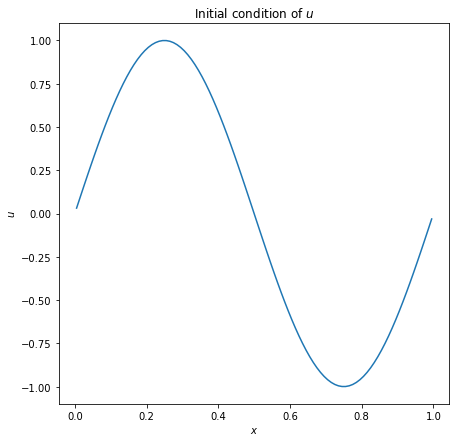

In [4]:
plt.figure(figsize=(7,7))
plt.plot(x, u_init, label="$\bar{u}$")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.title("Initial condition of $u$")
plt.show()

In [5]:
def dudt_central(u_bar, t, dx):
    # u_bar denotes average state in the cells, in formulas above denoted as \bar{u}_i.
    # f_bar denotes f(u_bar) in cell centers, using Burgers' equation f(u) = u^2/2
    
    # Flux f(u_i), computed for average state u_i in cell i.
    f_bar = u_bar**2 / 2
    
    # Flux at interface f_{i+1/2}
    f_interface = (f_bar[0:n-1] + f_bar[1:n]) / 2
    
    # Add flux at boundaries of the domain at interfaces f_{0-1/2} and f_{n+1/2}
    f_interface = np.hstack([0, f_interface, 0])
    
    # If we have n cells, we have n+1 cell boundaries.
    assert len(f_interface) == len(u_bar) + 1 
    
    # Compute the time derivative as the difference of flux directed into the cell.
    du_dt = (f_interface[0:n] - f_interface[1:n+1])/dx
    return du_dt


In [6]:
u = odeint(dudt_central, u_init, t, args=(dx,))

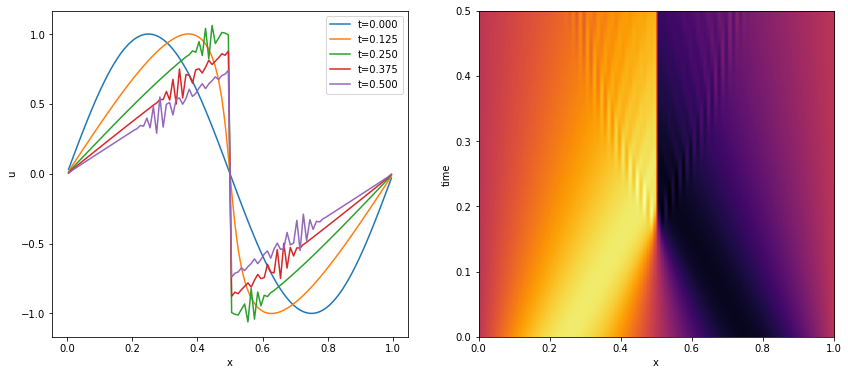

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
#axs[0].set_ylim(min(U0, Un),max(U0,Un))
axs[0].plot(x, u[0], label=f"t={0/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[49], label=f"t={50/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[99], label=f"t={100/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[149], label=f"t={150/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[199], label=f"t={200/t_steps*(tn-t0):.3f}")
axs[0].legend()
axs[0].set_ylabel("u")
axs[0].set_xlabel("x")
axs[1].imshow(u, aspect="auto", cmap="inferno", origin="lower", extent=[0, 1, t0, tn])
axs[1].set_xlabel(f"x")
axs[1].set_ylabel("time")
plt.show()

In [8]:
# Animation of the solution over the integrated time span.

def animate(frame):
    y = u[frame]
    line.set_data((x, y))
    plt.title(f"t={tn * frame / t_steps:0.2f}")

    
fig = plt.figure(figsize=(6, 6))
lines = plt.plot([])
line = lines[0]
plt.xlim([x0, xn])
plt.ylim([-1.1, 1.1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("")
  
anim = FuncAnimation(fig, animate, frames=t_steps, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()